In [1]:
import pandas as pd
import ast
import re
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

df = pd.read_excel("fr_tfidf.xlsx")

def clean_tfidf(x):
    s = str(x)
    s = s.replace("np.float64", "")
    s = s.replace("float64", "")
    s = s.replace("float32", "")
    s = re.sub(r"defaultdict\([^)]*\),?\s*", "", s)
    s = re.sub(r"\(\s*([0-9.]+)\s*\)", r"\1", s)
    d = ast.literal_eval(s)
    return {k: float(v) for k, v in d.items()}

tfidf_dicts = df["TFIDF"].apply(clean_tfidf)

vec = DictVectorizer(sparse=True)
X = vec.fit_transform(tfidf_dicts)

y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

param_grid = {
    "C": [0.01, 0.1, 1, 5, 10, 20, 50],
    "probability": [True]
}

search = RandomizedSearchCV(
    SVC(kernel="linear"),
    param_distributions=param_grid,
    n_iter=7,
    cv=3,
    scoring="f1_macro",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("\n=== BEST PARAMETERS ===")
print(search.best_params_)

best_model = search.best_estimator_

y_pred = best_model.predict(X_test)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 7 candidates, totalling 21 fits

=== BEST PARAMETERS ===
{'probability': True, 'C': 1}

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

          CG       0.88      0.87      0.88      4044
          OR       0.88      0.88      0.88      4043

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



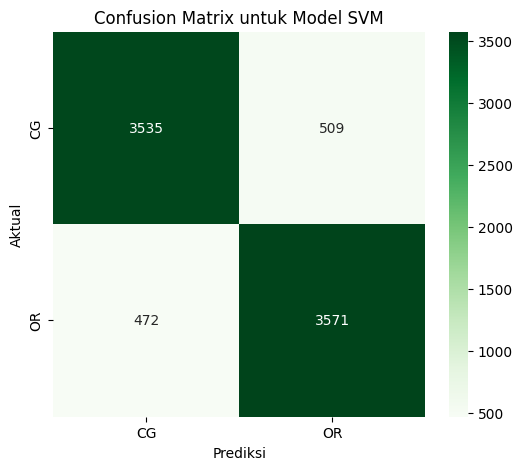

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = ["CG", "OR"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix untuk Model SVM")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()
